# Robust machine learning on streaming data using Kafka and Tensorflow-IO

## Overview

This tutorial focuses on streaming data from a [Kafka](https://kafka.apache.org/quickstart) cluster into a `tf.data.Dataset` which is then used in conjunction with `tf.keras` for training and inference.


**NOTE:** A Java runtime environment is required to run this tutorial.

## What is event streaming?

Technically speaking, event streaming is the practice of capturing data in real-time from event sources like databases, sensors, mobile devices, cloud services, and software applications in the form of streams of events; storing these event streams durably for later retrieval; manipulating, processing, and reacting to the event streams in real-time as well as retrospectively; and routing the event streams to different destination technologies as needed. Event streaming thus ensures a continuous flow and interpretation of data so that the right information is at the right place, at the right time.



## Apache Kafka is an event streaming platform. What does that mean?

Kafka combines three key capabilities so you can implement your use cases for event streaming end-to-end with a single battle-tested solution:

1. To **publish** (write) and **subscribe to** (read) streams of events, including continuous import/export of your data from other systems.
2. To **store** streams of events durably and reliably for as long as you want.
3. To **process** streams of events as they occur or retrospectively.


And all this functionality is provided in a distributed, highly scalable, elastic, fault-tolerant, and secure manner. Kafka can be deployed on bare-metal hardware, virtual machines, and containers, and on-premises as well as in the cloud. You can choose between self-managing your Kafka environments and using fully managed services offered by a variety of vendors.

## How does Kafka work in a nutshell?

Kafka is a distributed system consisting of servers and clients that communicate via a high-performance TCP network protocol. It can be deployed on bare-metal hardware, virtual machines, and containers in on-premise as well as cloud environments.

Servers: Kafka is run as a cluster of one or more servers that can span multiple datacenters or cloud regions. Some of these servers form the storage layer, called the brokers. Other servers run Kafka Connect to continuously import and export data as event streams to integrate Kafka with your existing systems such as relational databases as well as other Kafka clusters. To let you implement mission-critical use cases, a Kafka cluster is highly scalable and fault-tolerant: if any of its servers fails, the other servers will take over their work to ensure continuous operations without any data loss.

Clients: They allow you to write distributed applications and microservices that read, write, and process streams of events in parallel, at scale, and in a fault-tolerant manner even in the case of network problems or machine failures. Kafka ships with some such clients included, which are augmented by dozens of clients provided by the Kafka community: clients are available for Java and Scala including the higher-level Kafka Streams library, for Go, Python, C/C++, and many other programming languages as well as REST APIs.

## Main Concepts and Terminology

An **event** records the fact that "something happened" in the world or in your business. It is also called record or message in the documentation. When you read or write data to Kafka, you do this in the form of events. Conceptually, an event has a key, value, timestamp, and optional metadata headers. Here's an example event:

* Event key: "Alice"
* Event value: "Made a payment of $200 to Bob"
* Event timestamp: "Jun. 25, 2020 at 2:06 p.m."

**Producers** are those client applications that publish (write) events to Kafka, and **consumers** are those that subscribe to (read and process) these events. In Kafka, producers and consumers are fully decoupled and agnostic of each other, which is a key design element to achieve the high scalability that Kafka is known for. For example, producers never need to wait for consumers. Kafka provides various guarantees such as the ability to process events exactly-once.

Events are organized and durably stored in **topics**. Very simplified, a topic is similar to a folder in a filesystem, and the events are the files in that folder. An example topic name could be "payments". Topics in Kafka are always multi-producer and multi-subscriber: a topic can have zero, one, or many producers that write events to it, as well as zero, one, or many consumers that subscribe to these events. Events in a topic can be read as often as neededâ€”unlike traditional messaging systems, events are not deleted after consumption. Instead, you define for how long Kafka should retain your events through a per-topic configuration setting, after which old events will be discarded. Kafka's performance is effectively constant with respect to data size, so storing data for a long time is perfectly fine.

Topics are **partitioned**, meaning a topic is spread over a number of "buckets" located on different Kafka brokers. This distributed placement of your data is very important for scalability because it allows client applications to both read and write the data from/to many brokers at the same time. When a new event is published to a topic, it is actually appended to one of the topic's partitions. Events with the same event key (e.g., a customer or vehicle ID) are written to the same partition, and Kafka guarantees that any consumer of a given topic-partition will always read that partition's events in exactly the same order as they were written.

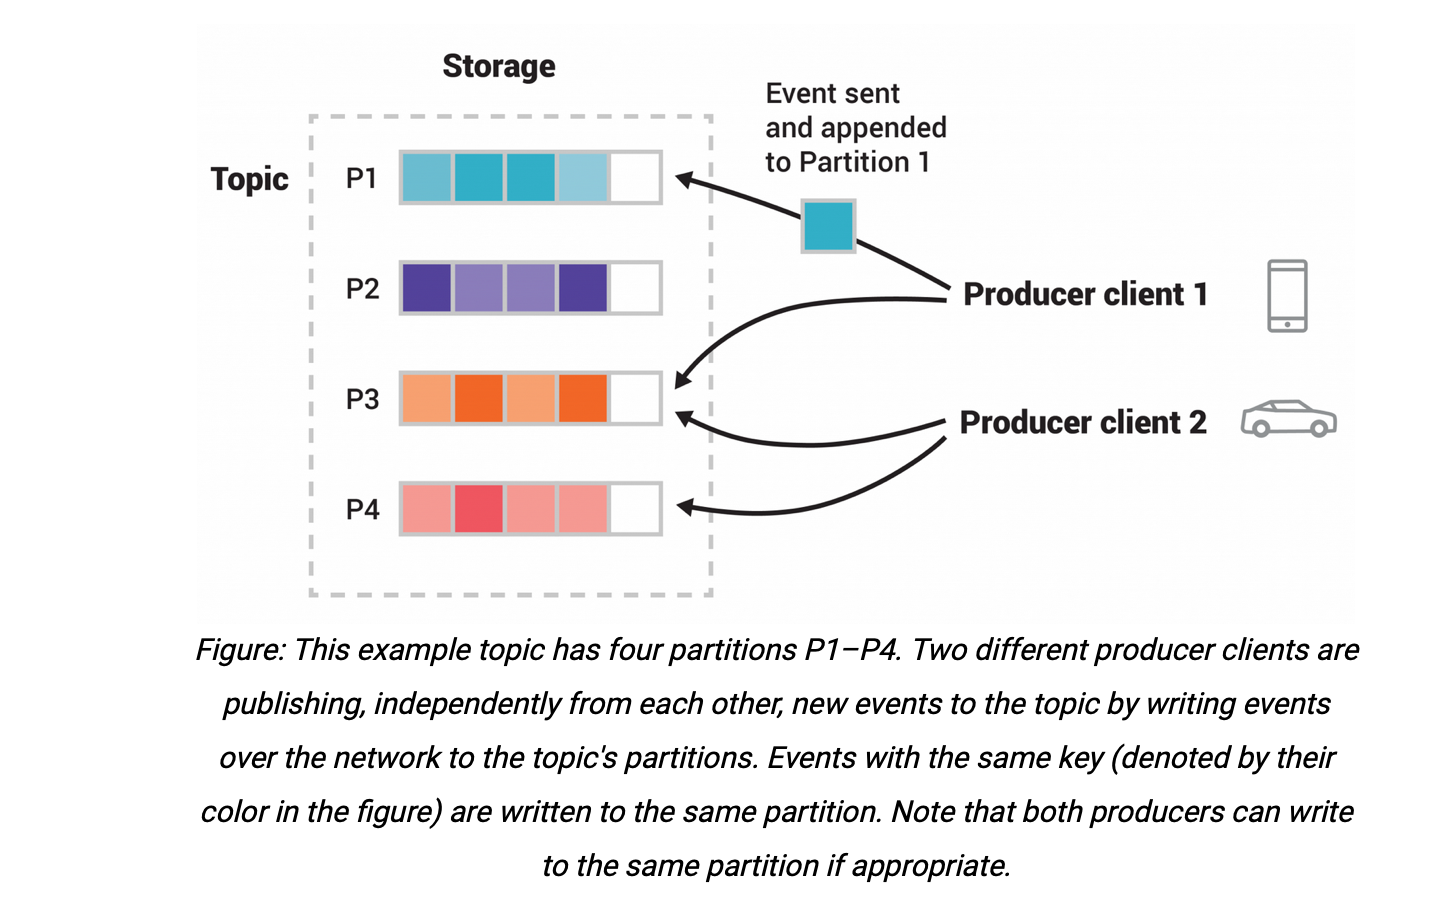

To make your data fault-tolerant and highly-available, every topic can be **replicated**, even across geo-regions or datacenters, so that there are always multiple brokers that have a copy of the data just in case things go wrong, you want to do maintenance on the brokers, and so on. A common production setting is a replication factor of 3, i.e., there will always be three copies of your data. This replication is performed at the level of topic-partitions.

This primer should be sufficient for an introduction. The Design section of the documentation explains Kafka's various concepts in full detail, if you are interested.

## Setup

### Install the required tensorflow-io and kafka packages

In [ ]:
!pip install tensorflow-io
!pip install kafka-python



### Import packages

In [ ]:
import os
from datetime import datetime
import time
import threading
import json
from kafka import KafkaProducer
from kafka.errors import KafkaError
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio

### Validate tf and tfio imports

In [ ]:
print("tensorflow-io version: {}".format(tfio.__version__))
print("tensorflow version: {}".format(tf.__version__))

tensorflow-io version: 0.20.0
tensorflow version: 2.6.0


## Download and setup Kafka and Zookeeper instances

For demo purposes, the following instances are setup locally:

- Kafka (Brokers: 127.0.0.1:9092)
- Zookeeper (Node: 127.0.0.1:2181)


In [ ]:
!curl -sSOL https://downloads.apache.org/kafka/2.7.0/kafka_2.13-2.7.0.tgz
!tar -xzf kafka_2.13-2.7.0.tgz

Using the default configurations (provided by Apache Kafka) for spinning up the instances.

In [ ]:
!./kafka_2.13-2.7.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-2.7.0/config/zookeeper.properties
!./kafka_2.13-2.7.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-2.7.0/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10


Waiting for 10 secs until kafka and zookeeper services are up and running


Once the instances are started as daemon processes, grep for `kafka` in the processes list. The two java processes correspond to zookeeper and the kafka instances.

In [ ]:
!ps -ef | grep kafka

root         720       1 12 16:19 ?        00:00:02 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xlog:gc*:file=/content/kafka_2.13-2.7.0/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=100M -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/kafka_2.13-2.7.0/bin/../logs -Dlog4j.configuration=file:./kafka_2.13-2.7.0/bin/../config/log4j.properties -cp /content/kafka_2.13-2.7.0/bin/../libs/activation-1.1.1.jar:/content/kafka_2.13-2.7.0/bin/../libs/aopalliance-repackaged-2.6.1.jar:/content/kafka_2.13-2.7.0/bin/../libs/argparse4j-0.7.0.jar:/content/kafka_2.13-2.7.0/bin/../libs/audience-annotations-0.5.0.jar:/content/kafka_2.13-2.7.0/bin/../libs/commons-cli-1.4.jar:/content/kafka_2.13-2.7.0/bin/../libs/commons-lang3-3.8.1.jar:/content/kafka_2.13

Create the kafka topics with the following specs:

- susy-train: partitions=1, replication-factor=1 
- susy-test: partitions=2, replication-factor=1 

In [ ]:
!./kafka_2.13-2.7.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic susy-train
!./kafka_2.13-2.7.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 2 --topic susy-test


Created topic susy-train.
Created topic susy-test.


Describe the topic for details on the configuration

In [ ]:
!./kafka_2.13-2.7.0/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic susy-train
!./kafka_2.13-2.7.0/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic susy-test


Topic: susy-train	PartitionCount: 1	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: susy-train	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
Topic: susy-test	PartitionCount: 2	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: susy-test	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
	Topic: susy-test	Partition: 1	Leader: 0	Replicas: 0	Isr: 0


The replication factor 1 indicates that the data is not being replicated. This is due to the presence of a single broker in our kafka setup.
In production systems, the number of bootstrap servers can be in the range of 100's of nodes. That is where the fault-tolerance using replication comes into picture.

Please refer to the [docs](https://kafka.apache.org/documentation/#replication) for more details.


## SUSY Dataset

Kafka being an event streaming platform, enables  data from various sources to be written into it. For instance:

- Web traffic logs
- Astronomical measurements
- IoT sensor data
- Product reviews and many more.

For the purpose of this tutorial, lets download the [SUSY](https://archive.ics.uci.edu/ml/datasets/SUSY#) dataset and feed the data into kafka manually. The goal of this classification problem is to distinguish between a signal process which produces supersymmetric particles and a background process which does not.


In [ ]:
!curl -sSOL https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz

### Explore the dataset

The first column is the class label (1 for signal, 0 for background), followed by the 18 features (8 low-level features then 10 high-level features).
The first 8 features are kinematic properties measured by the particle detectors in the accelerator. The last 10 features are functions of the first 8 features. These are high-level features derived by physicists to help discriminate between the two classes.

In [ ]:
COLUMNS = [
          #  labels
           'class',
          #  low-level features
           'lepton_1_pT',
           'lepton_1_eta',
           'lepton_1_phi',
           'lepton_2_pT',
           'lepton_2_eta',
           'lepton_2_phi',
           'missing_energy_magnitude',
           'missing_energy_phi',
          #  high-level derived features
           'MET_rel',
           'axial_MET',
           'M_R',
           'M_TR_2',
           'R',
           'MT2',
           'S_R',
           'M_Delta_R',
           'dPhi_r_b',
           'cos(theta_r1)'
           ]

The entire dataset consists of 5 million rows. However, for the purpose of this tutorial, let's consider only a fraction of the dataset (100,000 rows) so that less time is spent on the moving the data and more time on understanding the functionality of the api.

In [ ]:
susy_iterator = pd.read_csv('SUSY.csv.gz', header=None, names=COLUMNS, chunksize=100000)
susy_df = next(susy_iterator)
susy_df.head()

,class,lepton_1_pT,lepton_1_eta,lepton_1_phi,lepton_2_pT,lepton_2_eta,lepton_2_phi,missing_energy_magnitude,missing_energy_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [ ]:
# Number of datapoints and columns
len(susy_df), len(susy_df.columns)

(100000, 19)

In [ ]:
# Number of datapoints belonging to each class (0: background noise, 1: signal)
len(susy_df[susy_df["class"]==0]), len(susy_df[susy_df["class"]==1])

(54025, 45975)

### Split the dataset


In [ ]:
train_df, test_df = train_test_split(susy_df, test_size=0.4, shuffle=True)
print("Number of training samples: ",len(train_df))
print("Number of testing sample: ",len(test_df))

x_train_df = train_df.drop(["class"], axis=1)
y_train_df = train_df["class"]

x_test_df = test_df.drop(["class"], axis=1)
y_test_df = test_df["class"]

# The labels are set as the kafka message keys so as to store data
# in multiple-partitions. Thus, enabling efficient data retrieval
# using the consumer groups.
x_train = list(filter(None, x_train_df.to_csv(index=False).split("\n")[1:]))
y_train = list(filter(None, y_train_df.to_csv(index=False).split("\n")[1:]))

x_test = list(filter(None, x_test_df.to_csv(index=False).split("\n")[1:]))
y_test = list(filter(None, y_test_df.to_csv(index=False).split("\n")[1:]))


Number of training samples:  60000
Number of testing sample:  40000


In [ ]:
NUM_COLUMNS = len(x_train_df.columns)
len(x_train), len(y_train), len(x_test), len(y_test)

(60000, 60000, 40000, 40000)

### Store the train and test data in kafka

Storing the data in kafka simulates an environment for continuous remote data retrieval for training and inference purposes.

In [ ]:
def error_callback(exc):
    raise Exception('Error while sendig data to kafka: {0}'.format(str(exc)))

def write_to_kafka(topic_name, items):
  count=0
  producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'])
  for message, key in items:
    producer.send(topic_name, key=key.encode('utf-8'), value=message.encode('utf-8')).add_errback(error_callback)
    count+=1
  producer.flush()
  print("Wrote {0} messages into topic: {1}".format(count, topic_name))

write_to_kafka("susy-train", zip(x_train, y_train))
write_to_kafka("susy-test", zip(x_test, y_test))


Wrote 60000 messages into topic: susy-train
Wrote 40000 messages into topic: susy-test


### Define the tfio train dataset

The `IODataset` class is utilized for streaming data from kafka into tensorflow. The class inherits from `tf.data.Dataset` and thus has all the useful functionalities of `tf.data.Dataset` out of the box.


In [ ]:
def decode_kafka_item(item):
  message = tf.io.decode_csv(item.message, [[0.0] for i in range(NUM_COLUMNS)])
  key = tf.strings.to_number(item.key)
  return (message, key)

BATCH_SIZE=64
SHUFFLE_BUFFER_SIZE=64
train_ds = tfio.IODataset.from_kafka('susy-train', partition=0, offset=0)


In [ ]:
train_ds = train_ds.map(decode_kafka_item)

In [ ]:
train_ds = train_ds.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
train_ds = train_ds.batch(BATCH_SIZE)

## Build and train the model


In [ ]:
# Set the parameters

OPTIMIZER="adam"
LOSS=tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS=['accuracy']
EPOCHS=10


In [ ]:
# design/build the model
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(NUM_COLUMNS,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2432      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [ ]:
# compile the model
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

In [ ]:
# fit the model
model.fit(train_ds, epochs=EPOCHS)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


938/938 [==============================] - 35s 34ms/step - loss: 0.4848 - accuracy: 0.7680
Epoch 2/10
938/938 [==============================] - 32s 34ms/step - loss: 0.4561 - accuracy: 0.7875
Epoch 3/10
938/938 [==============================] - 32s 34ms/step - loss: 0.4518 - accuracy: 0.7902
Epoch 4/10
938/938 [==============================] - 32s 34ms/step - loss: 0.4487 - accuracy: 0.7920
Epoch 5/10
938/938 [==============================] - 32s 34ms/step - loss: 0.4480 - accuracy: 0.7932
Epoch 6/10
938/938 [==============================] - 32s 34ms/step - loss: 0.4465 - accuracy: 0.7929
Epoch 7/10
938/938 [==============================] - 32s 34ms/step - loss: 0.4456 - accuracy: 0.7930
Epoch 8/10
938/938 [==============================] - 32s 34ms/step - loss: 0.4446 - accuracy: 0.7943
Epoch 9/10
938/938 [==============================] - 32s 34ms/step - loss: 0.4438 - accuracy: 0.7946
Epoch 10/10
938/938 [==============================] - 32s 34ms/step - loss: 0.4430 - accurac

Note: Please do not confuse the training step with online training. It's an entirely different paradigm which will be covered in a later section.

Since only a fraction of the dataset is being utilized, our accuracy is limited to ~78% during the training phase. However, please feel free to store additional data in kafka for a better model performance. Also, since the goal was to just demonstrate the functionality of the tfio kafka datasets, a smaller and less-complicated neural network was used. However, one can increase the complexity of the model, modify the learning strategy, tune hyper-parameters etc for exploration purposes. For a baseline approach, please refer to this [article](https://www.nature.com/articles/ncomms5308#Sec11).

## Infer on the test data

To infer on the test data by adhering to the 'exactly-once' semantics along with fault-tolerance, the `streaming.KafkaGroupIODataset` can be utilized. 


### Define the tfio test dataset

The `stream_timeout` parameter blocks for the given duration for new data points to be streamed into the topic. This removes the need for creating new datasets if the data is being streamed into the topic in an intermittent fashion.

In [ ]:
test_ds = tfio.experimental.streaming.KafkaGroupIODataset(
    topics=["susy-test"],
    group_id="testcg",
    servers="127.0.0.1:9092",
    stream_timeout=10000,
    configuration=[
        "session.timeout.ms=7000",
        "max.poll.interval.ms=8000",
        "auto.offset.reset=earliest"
    ],
)

def decode_kafka_test_item(raw_message, raw_key):
  message = tf.io.decode_csv(raw_message, [[0.0] for i in range(NUM_COLUMNS)])
  key = tf.strings.to_number(raw_key)
  return (message, key)

test_ds = test_ds.map(decode_kafka_test_item)
test_ds = test_ds.batch(BATCH_SIZE)

Instructions for updating:
Use `tf.data.Dataset.scan(...) instead
Instructions for updating:
Use `tf.data.Dataset.take_while(...)


Though this class can be used for training purposes, there are caveats which need to be addressed. Once all the messages are read from kafka and the latest offsets are committed using the `streaming.KafkaGroupIODataset`, the consumer doesn't restart reading the messages from the beginning. Thus, while training, it is possible only to train for a single epoch with the data continuously flowing in. This kind of a functionality has limited use cases during the training phase wherein, once a datapoint has been consumed by the model it is no longer required and can be discarded.

However, this functionality shines when it comes to robust inference with exactly-once semantics.

### evaluate the performance on the test data


In [ ]:
res = model.evaluate(test_ds)
print("test loss, test acc:", res)


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


625/625 [==============================] - 24s 37ms/step - loss: 0.4395 - accuracy: 0.7979
test loss, test acc: [0.43949612975120544, 0.7978749871253967]


Since the inference is based on 'exactly-once' semantics, the evaluation on the test set can be run only once. In order to run the inference again on the test data, a new consumer group should be used.

### Track the offset lag of the `testcg` consumer group

In [ ]:
!./kafka_2.13-2.7.0/bin/kafka-consumer-groups.sh --bootstrap-server 127.0.0.1:9092 --describe --group testcg



Consumer group 'testcg' has no active members.

GROUP           TOPIC           PARTITION  CURRENT-OFFSET  LOG-END-OFFSET  LAG             CONSUMER-ID     HOST            CLIENT-ID
testcg          susy-test       0          21737           21737           0               -               -               -
testcg          susy-test       1          18263           18263           0               -               -               -


Once the `current-offset` matches the `log-end-offset` for all the partitions, it indicates that the consumer(s) have completed fetching all the messages from the kafka topic.

## Online learning

The online machine learning paradigm is a bit different from the traditional/conventional way of training machine learning models. In the former case, the model continues to incrementally learn/update it's parameters as soon as the new data points are available and this process is expected to continue indefinitely. This is unlike the latter approaches where the dataset is fixed and the model iterates over it `n` number of times. In online learning, the data once consumed by the model may not be available for training again.

By utilizing the `streaming.KafkaBatchIODataset`, it is now possible to train the models in this fashion. Let's continue to use our SUSY dataset for demonstrating this functionality.

### The tfio training dataset for online learning

The `streaming.KafkaBatchIODataset` is similar to the `streaming.KafkaGroupIODataset` in it's API. Additionally, it is recommended to utilize the `stream_timeout` parameter to configure the duration for which the dataset will block for new messages before timing out. In the instance below, the dataset is configured with a `stream_timeout` of `10000` milliseconds. This implies that, after all the messages from the topic have been consumed, the dataset will wait for an additional 10 seconds before timing out and disconnecting from the kafka cluster. If new messages are streamed into the topic before timing out, the data consumption and model training resumes for those newly consumed data points. To block indefinitely, set it to `-1`.

In [ ]:
online_train_ds_cpy = tfio.experimental.streaming.KafkaBatchIODataset(
    topics=["susy-train"],
    group_id="cgonline",
    servers="127.0.0.1:9092",
    stream_timeout=10000, # in milliseconds, to block indefinitely, set it to -1.
    configuration=[
        "session.timeout.ms=7000",
        "max.poll.interval.ms=8000",
        "auto.offset.reset=earliest"
    ],
)

Every item that the `online_train_ds` generates is a `tf.data.Dataset` in itself. Thus, all the standard transformations can be applied as usual.


In [ ]:
def decode_kafka_online_item(raw_message, raw_key):
  message = tf.io.decode_csv(raw_message, [[0.0] for i in range(NUM_COLUMNS)])
  key = tf.strings.to_number(raw_key)
  return (message, key)
  
for mini_ds in online_train_ds_cpy:
  mini_ds = mini_ds.shuffle(buffer_size=32)
  mini_ds = mini_ds.map(decode_kafka_online_item)
  mini_ds = mini_ds.batch(32)
  model.fit(mini_ds, epochs=1)


ValueError: ignored

The incrementally trained model can be saved in a periodic fashion (based on use-cases) and can be utilized to infer on the test data in either online or offline modes.

Note: The `streaming.KafkaBatchIODataset` and `streaming.KafkaGroupIODataset` are still in experimental phase and have scope for improvements based on user-feedback.

## References:

- Baldi, P., P. Sadowski, and D. Whiteson. â€œSearching for Exotic Particles in High-energy Physics with Deep Learning.â€ Nature Communications 5 (July 2, 2014)

- SUSY Dataset: https://archive.ics.uci.edu/ml/datasets/SUSY#

- Apache Kafka documentation: https://kafka.apache.org/documentation